In [52]:
#Ens connectem a la GPU
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [53]:
#Lliberies utilitzades
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from tqdm import tqdm
import nibabel as nib
import cv2
import numpy as np
from sklearn.model_selection import KFold

In [55]:
path = "HGG/HGG/"

In [72]:
#Funció per llegir les imatges de la base de dades
def load_data(path,mida):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  i=1
  for p in tqdm(my_dir): 
    if(p.startswith('Brats18')):
        data_list = sorted(os.listdir(path+p))       
    
        seg = nib.load(path + p + '/'+ data_list[1]).get_fdata()
        
        flair = nib.load(path + p + '/'+ data_list[0]).get_fdata()
        
        t2 = nib.load(path + p + '/'+ data_list[4]).get_fdata()

        data.append([flair,t2])
        gt.append(seg)
    if i>mida:
      break
    else:
      i=i+1
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data,gt,flair

In [73]:
nombre_mostres=285

In [74]:
data1,gt1,flair = load_data(path,nombre_mostres)   #dividing HGG in three parts i.e. 210 into three sets of 70 

  2%|▏         | 5/287 [00:01<01:41,  2.77it/s]


In [78]:
#Modifiquem la forma dels vectors
data = np.transpose(data1,(0,4,2,3,1))
gt1=np.swapaxes(gt1,1,3)
gt1=np.swapaxes(gt1,2,3)
data = data.reshape([-1,240,240,2])
gt_final = gt1.reshape([-1,240,240,1])

In [83]:
#Canviem els valors del vector gt_final
gt_final[np.where(gt!=0)]=1

In [27]:
#Estructura de la U-NET
def unet():
    
    inputs = Input((240 , 240 , 2))
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512,3, activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(batch4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization()(conv5)
    
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', activation='relu') (batch5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same') (up6)
    batch6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512,3, activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization()(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', activation='relu') (batch6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256,3, activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256,3, activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization()(conv7)
    
    up8 = Conv2DTranspose(128,2, strides=(2, 2), padding='same', activation='relu') (batch7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128,3, activation='relu', padding='same') (up8)
    batch8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128,3, activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64,2, strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1,1,activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

    return model

In [28]:
#Dividim la base de dades en train i test
percentatge=abs(nombre_mostres*0.8)
#Train
input_train=data[0:int(percentatge*155),:,:,:]
target_train=gt_final[0:int(percentatge*155),:,:]
#Test
input_test=data[int(percentatge*155):,:,:,:]
target_test=gt_final[int(percentatge*155):,:,:,:]


In [30]:
#Funcions que calculen el dice
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    mean_dice_channel = 0.
    vector_dice=[]
    compt=1
    total_dice=[]
    for i in range(batch_size):
        if compt==155:
                vector_dice.append(dice_coef(y_true[i, :, :, 0], y_pred_bin[i, :, :,0]))
                total_dice.append(np.mean(vector_dice))
                vector_dice=[]
                compt=1
        else:
                vector_dice.append(dice_coef(y_true[i, :, :, 0], y_pred_bin[i, :, :,0]))
                compt=compt+1
    return total_dice

In [31]:
num_folds=5
inputs = input_train
targets =target_train
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=100)
fold_no=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
28272/28272 [==============================] - 903s 32ms/step - loss: 1.1972
Epoch 2/50
28272/28272 [==============================] - 897s 32ms/step - loss: 0.0961
Epoch 3/50
28272/28272 [==============================] - 897s 32ms/step - loss: 0.0586
Epoch 4/50
28272/28272 [==============================] - 897s 32ms/step - loss: 0.0465
Epoch 5/50
28272/28272 [==============================] - 898s 32ms/step - loss: 0.0397
Epoch 6/50
28272/28272 [==============================] - 897s 32ms/step - loss: 0.0352
Epoch 7/50
28272/28272 [==============================] - 898s 32ms/step - loss: 0.0312
Epoch 8/50
28272/28272 [==============================] - 898s 32ms/step - loss: 0.0281
Epoch 9/50
28272/28272 [==============================] - 898s 32ms/step - loss: 0.0263
Epoch 10/50
28272/28272 [==============================] - 898s 32ms/step - loss: 0.0245
Epoch 11/50
28272/2827

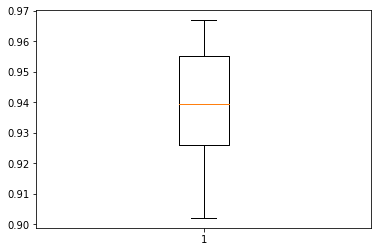

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
28272/28272 [==============================] - 912s 32ms/step - loss: 1.1676
Epoch 2/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0927
Epoch 3/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0563
Epoch 4/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0471
Epoch 5/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0386
Epoch 6/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0346
Epoch 7/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0310
Epoch 8/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0289
Epoch 9/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0264
Epoch 10/50
28272/28272 [==============================] - 906s 32ms/step - loss: 0.0248
Epoch 11/50
28272/2827

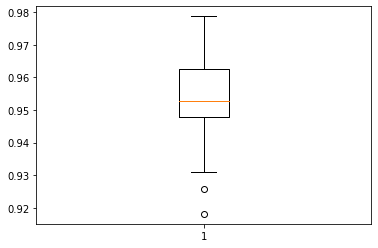

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
28272/28272 [==============================] - 909s 32ms/step - loss: 1.2128
Epoch 2/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0925
Epoch 3/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0526
Epoch 4/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0424
Epoch 5/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0361
Epoch 6/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0319
Epoch 7/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0288
Epoch 8/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0269
Epoch 9/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0242
Epoch 10/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0226
Epoch 11/50
28272/2827

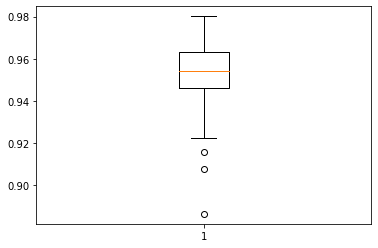

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
28272/28272 [==============================] - 913s 32ms/step - loss: 1.1171
Epoch 2/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0954
Epoch 3/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0536
Epoch 4/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0434
Epoch 5/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0385
Epoch 6/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0326
Epoch 7/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0312
Epoch 8/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0271
Epoch 9/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0253
Epoch 10/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.0240
Epoch 11/50
28272/2827

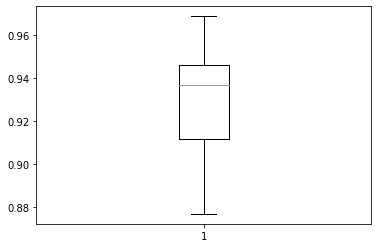

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
28272/28272 [==============================] - 917s 32ms/step - loss: 1.1991
Epoch 2/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0885
Epoch 3/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0571
Epoch 4/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0443
Epoch 5/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0398
Epoch 6/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0337
Epoch 7/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0297
Epoch 8/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0279
Epoch 9/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0253
Epoch 10/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0234
Epoch 11/50
28272/2827

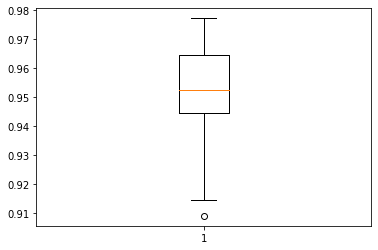

In [34]:
#Entrenem els models
loss_per_fold=[]
vec_models=[]
scores_dice_total=[]
for train, test in kfold.split(inputs, targets):
    model = unet()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],batch_size=8,epochs=50)
    vec_models.append(model)

    #Predim el model
    prediccio=model.predict(inputs[test])
    dades=inputs[test]
    dades[np.where(dades>0)]=1
    prediccio=prediccio*dades
    prediccio[np.where(prediccio<0.5)]=0
    prediccio[np.where(prediccio>=0.5)]=1
    
    #Calculem dice del model corresponent
    score=mean_dice_coef(prediccio,targets[test])
    
    #Calculem loss del model corresponent
    scores_lose = model.evaluate(inputs[test], targets[test], verbose=0)
    
    #Mostrem els resultats
    scores_dice=np.mean(score)
    dice_coeficient="['dice_coef']"
    print(f'Score for fold {fold_no}: {model.metrics_names} of {scores_lose}%')
    print(f'Score for fold {fold_no}: {dice_coeficient} of {scores_dice}%')
    
    #Creem boxplot
    plt.boxplot(score)
    plt.show()
    scores_dice_total.append(score)
    score=[]
    prediccio=[]
    score_dice=0
    loss_per_fold.append(scores_lose)
    fold_no = fold_no + 1
    

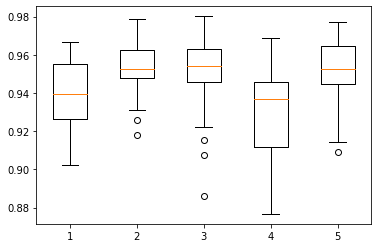

In [35]:
plt.boxplot(scores_dice_total)
plt.show()

In [36]:
vec_models[0].save('#1.1#SB_5_fold_50_epochs.h5')
vec_models[1].save('#1.2#SB_5_fold_50_epochs.h5')
vec_models[2].save('#1.3#SB_5_fold_50_epochs.h5')
vec_models[3].save('#1.4#SB_5_fold_50_epochs.h5')
vec_models[4].save('#1.5#SB_5_fold_50_epochs.h5')

# AGAFEM EL MAXIM DELS 5 MODELS

In [38]:
Y_pre1=vec_models[0].predict(input_test)
Y_pre2=vec_models[1].predict(input_test)
Y_pre3=vec_models[2].predict(input_test)
Y_pre4=vec_models[3].predict(input_test)
Y_pre5=vec_models[4].predict(input_test)

Dice maxim dels 5 models: 0.7644948303268715%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f049bd6b630>,
 'caps': [<matplotlib.lines.Line2D at 0x7f049bd6bbe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f049bd6b3c8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f049bd771d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f049bd774a8>],
 'means': []}

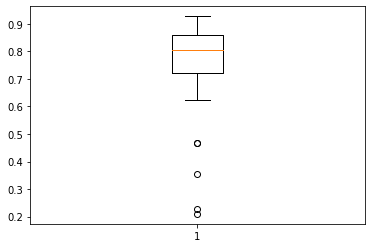

In [39]:
#Creem un model amb el valor del píxel més gran de tots els 5 models
Y_pre_total_maxim=np.maximum(Y_pre1,Y_pre2)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre3)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre4)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre5)

Y_pre_total_maxim[np.where(Y_pre_total_maxim<0.5)]=0
Y_pre_total_maxim[np.where(Y_pre_total_maxim>=0.5)]=1

input_test=np.array(input_test,copy=True)
input_test2=input_test.copy()
input_test2[np.where(input_test2>0)]=1
Y_pre_total_maxim=Y_pre_total_maxim*input_test2

#Calculem accuracy
dades=mean_dice_coef(target_test, Y_pre_total_maxim)
print(f'Dice maxim dels 5 models: {np.mean(dades)}%')
plt.boxplot(dades)

input_test 80


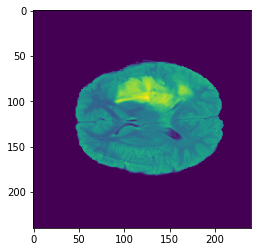

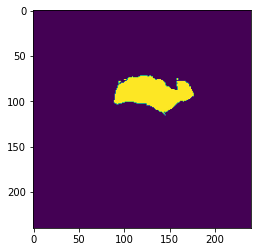

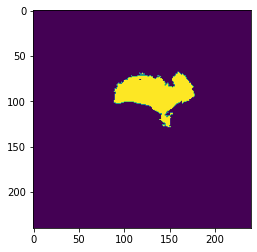

input_test 81


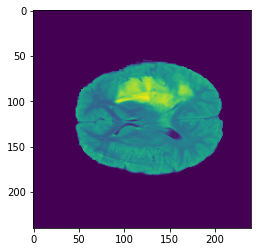

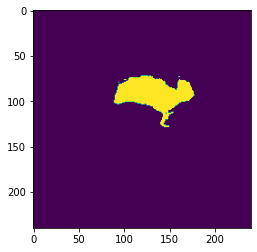

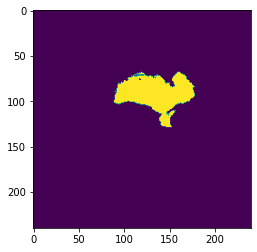

input_test 82


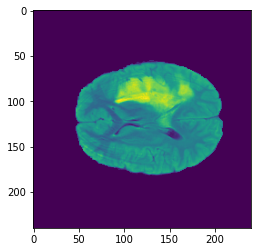

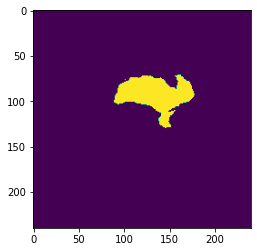

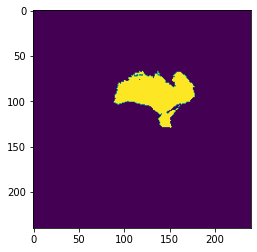

input_test 83


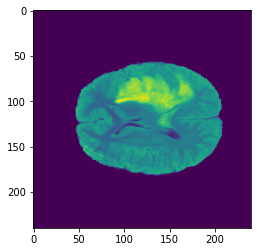

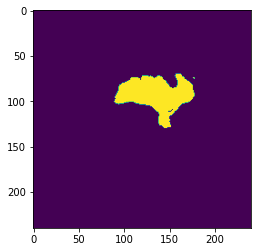

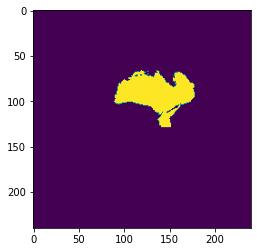

input_test 84


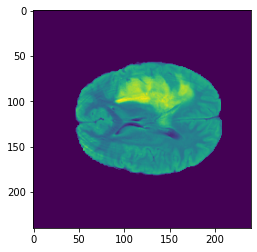

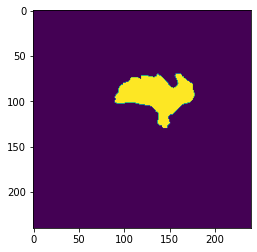

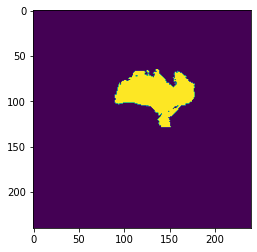

input_test 85


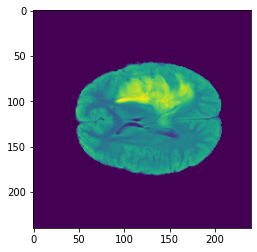

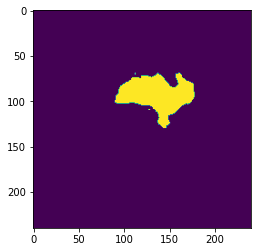

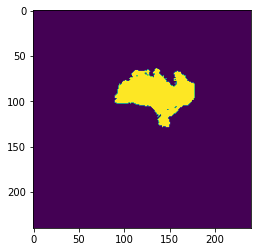

input_test 86


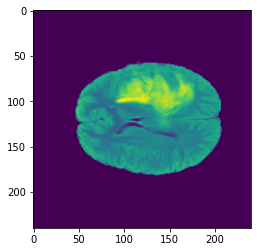

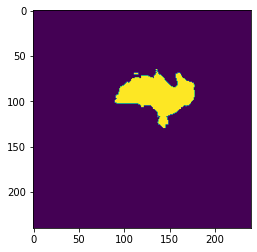

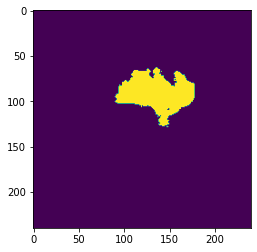

input_test 87


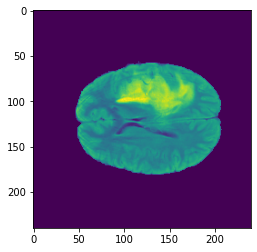

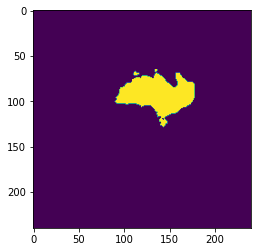

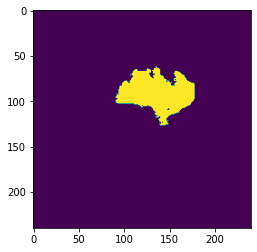

input_test 88


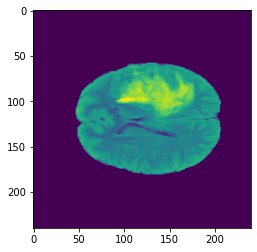

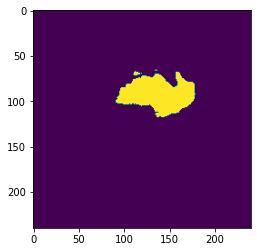

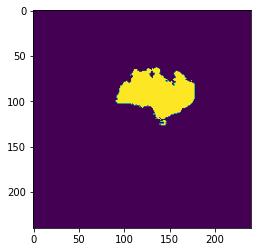

input_test 89


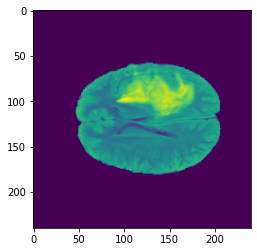

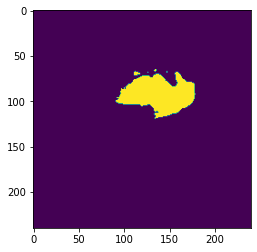

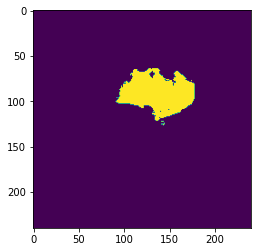

In [40]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_total_maxim[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# AGAFEM LA MITJANA DELS 5 MODELS

Mitjana dels 5 models: 0.8361523970429292%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f049b2d57f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f049b2d5da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f049b2d5588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f049b2e4390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f049b2e4668>],
 'means': []}

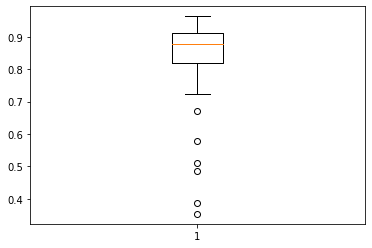

In [41]:
#Creem un model amb la mitjana dels valors dels píxels dels 5 models
Y_pre_total_mitjana=Y_pre1+Y_pre2+Y_pre3+Y_pre4+Y_pre5
Y_pre_total_mitjana=Y_pre_total_mitjana/5

Y_pre_total_mitjana[np.where(Y_pre_total_mitjana<0.5)]=0
Y_pre_total_mitjana[np.where(Y_pre_total_mitjana>=0.5)]=1
Y_pre_total_mitjana=Y_pre_total_mitjana*input_test2

#Calculem accuracy
dades=mean_dice_coef(target_test, Y_pre_total_mitjana)
print(f'Mitjana dels 5 models: {np.mean(dades)}%')
plt.boxplot(dades)

input_test 80


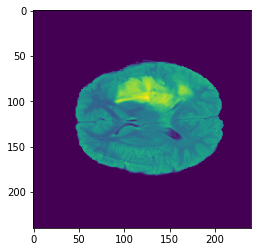

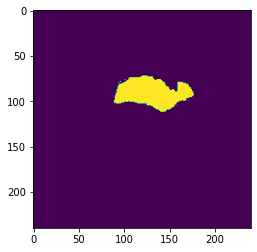

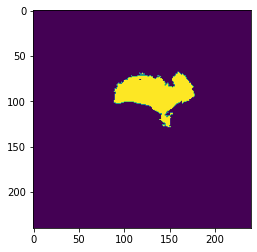

input_test 81


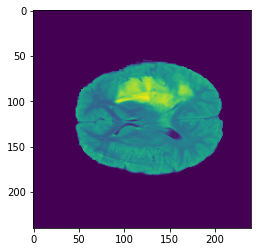

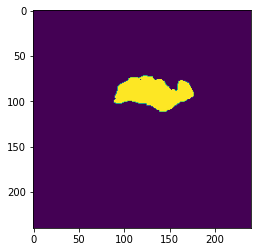

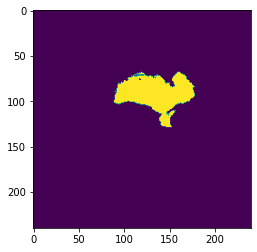

input_test 82


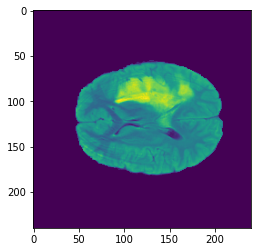

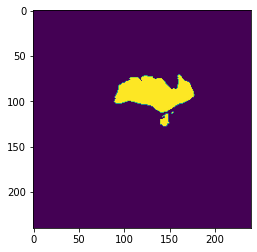

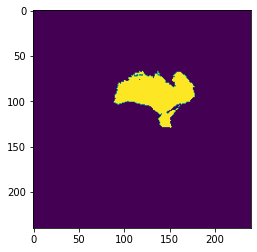

input_test 83


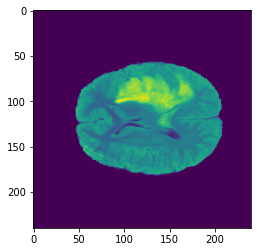

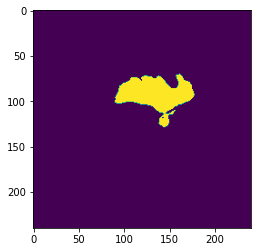

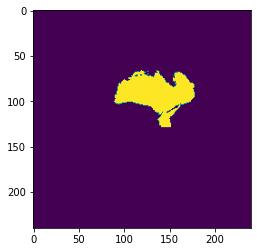

input_test 84


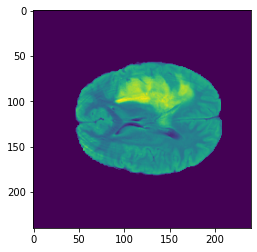

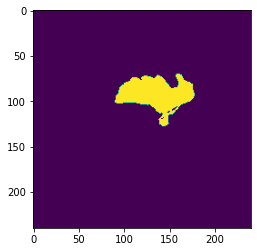

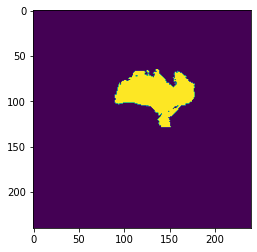

input_test 85


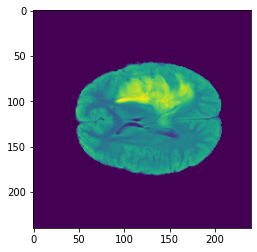

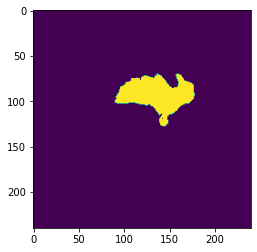

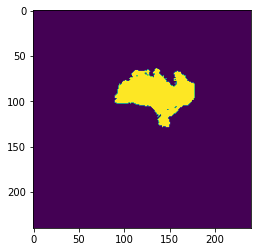

input_test 86


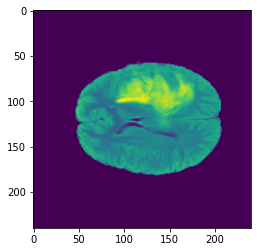

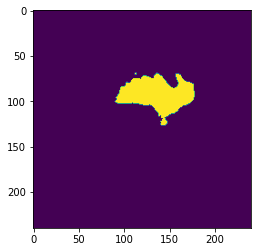

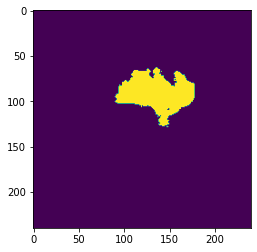

input_test 87


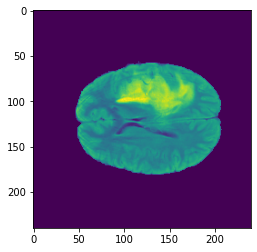

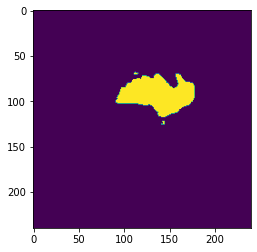

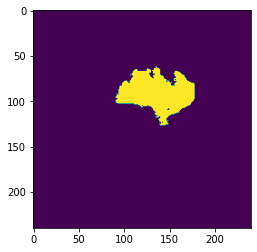

input_test 88


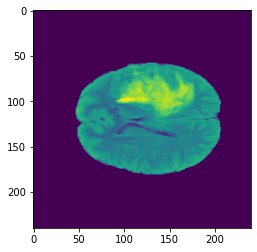

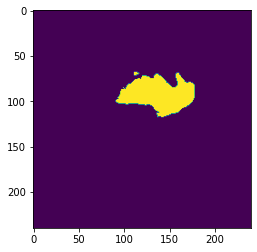

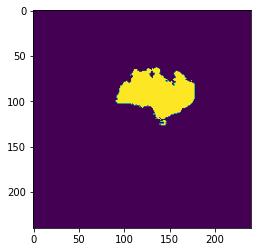

input_test 89


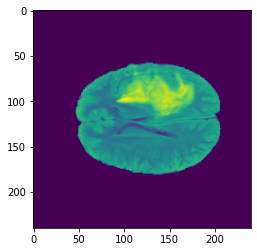

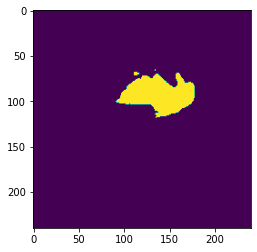

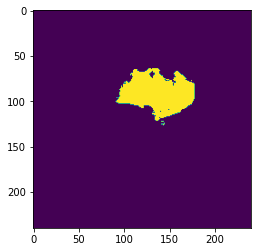

In [42]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_total_mitjana[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# AGAFEM EL MODEL AMB LA LOSS MÉS BAIXA

Dice loss més petita: 0.8093699312490396%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f049a7bef28>,
 'caps': [<matplotlib.lines.Line2D at 0x7f049a7cb518>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f049a7becc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f049a7cbac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f049a7cbda0>],
 'means': []}

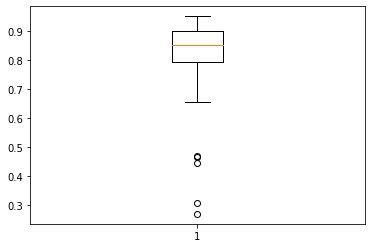

In [43]:
#Ens quedem amb el model amb la loss més baixa
index_lowest_loss=np.where(loss_per_fold==np.min(loss_per_fold))
index_lowest_loss=np.asarray(index_lowest_loss)
np.savetxt('#2.6# index.txt',index_lowest_loss)
valor=int(index_lowest_loss[0])
model_lowest_low=vec_models[valor]

Y_pre_lowest_low=model_lowest_low.predict(input_test)
Y_pre_lowest_low[np.where(Y_pre_lowest_low<0.5)]=0
Y_pre_lowest_low[np.where(Y_pre_lowest_low>=0.5)]=1
Y_pre_lowest_low=Y_pre_lowest_low*input_test2

#Calculem dice
dades=mean_dice_coef(target_test, Y_pre_lowest_low)
print(f'Dice loss més petita: {np.mean(dades)}%')
plt.boxplot(dades)

input_test 80


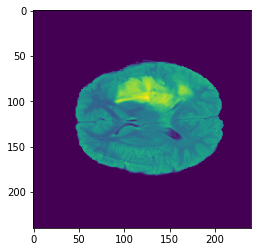

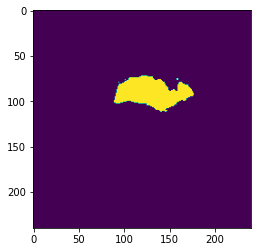

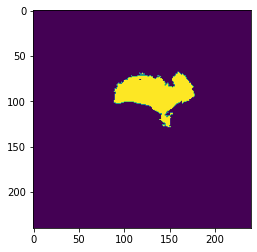

input_test 81


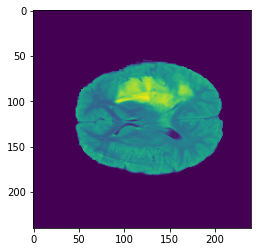

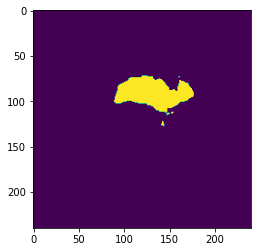

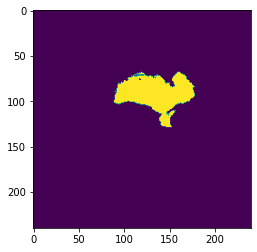

input_test 82


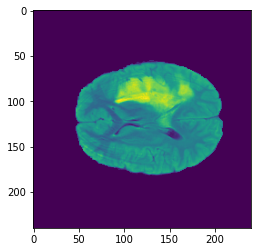

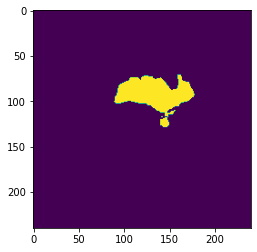

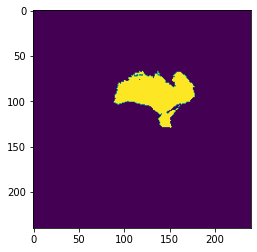

input_test 83


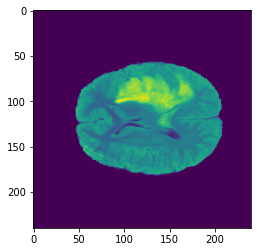

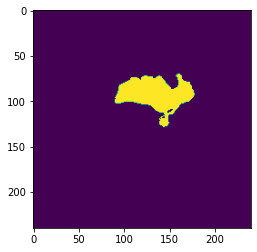

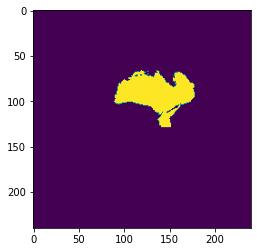

input_test 84


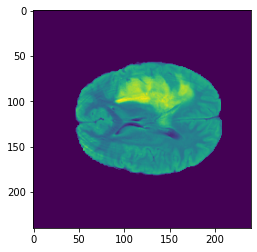

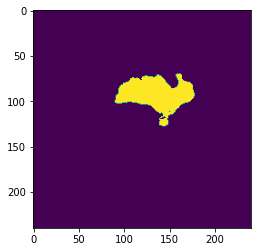

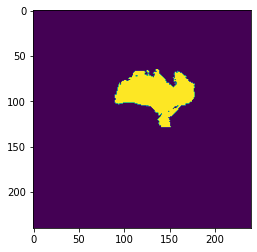

input_test 85


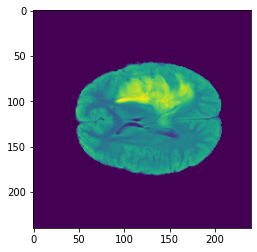

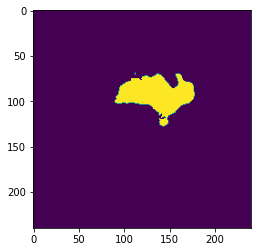

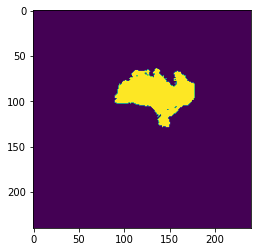

input_test 86


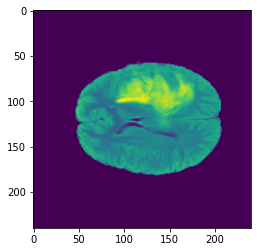

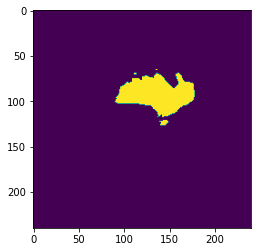

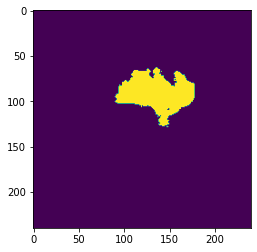

input_test 87


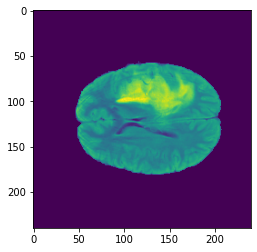

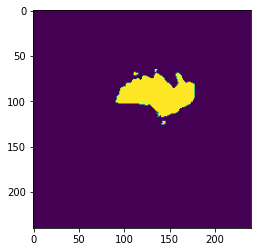

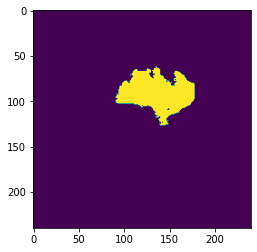

input_test 88


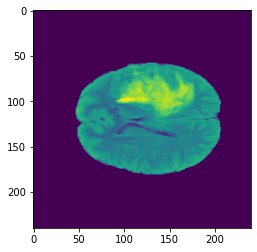

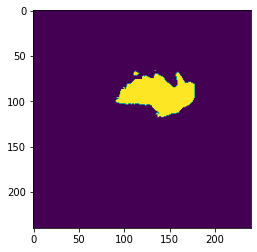

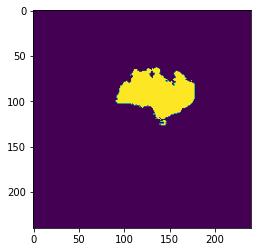

input_test 89


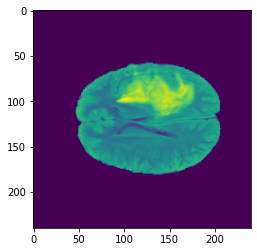

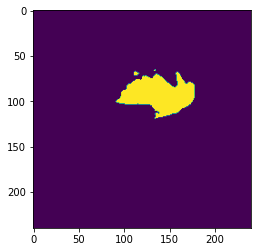

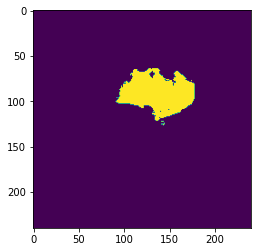

In [44]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_lowest_low[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# Mirem el dice de tots els models amb les imatges de test

Dice model 1: 0.8033728901493656%
Dice model 2: 0.8093699312490396%
Dice model 3: 0.8090979746016911%
Dice model 4: 0.7986209980764658%
Dice model 5: 0.8154041729249243%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0491c947f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0491c94da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0491c94588>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0491ca3390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0491ca3668>,
 'means': []}

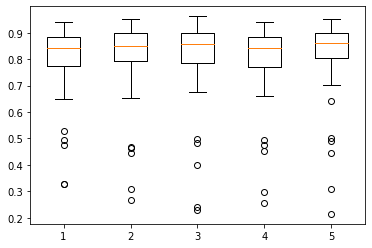

In [45]:
#Mirem dice dels 5 models per separat
dades_totals=[]
Y_pre1[np.where(Y_pre1<0.5)]=0
Y_pre1[np.where(Y_pre1>=0.5)]=1
Y_pre1=Y_pre1*input_test2
dades1=mean_dice_coef(target_test, Y_pre1)
print(f'Dice model 1: {np.mean(dades1)}%')
dades_totals.append(dades1)

Y_pre2[np.where(Y_pre2<0.5)]=0
Y_pre2[np.where(Y_pre2>=0.5)]=1
Y_pre2=Y_pre2*input_test2
dades2=mean_dice_coef(target_test, Y_pre2)
print(f'Dice model 2: {np.mean(dades2)}%')
dades_totals.append(dades2)

Y_pre3[np.where(Y_pre3<0.5)]=0
Y_pre3[np.where(Y_pre3>=0.5)]=1
Y_pre3=Y_pre3*input_test2
dades3=mean_dice_coef(target_test, Y_pre3)
print(f'Dice model 3: {np.mean(dades3)}%')
dades_totals.append(dades3)

Y_pre4[np.where(Y_pre4<0.5)]=0
Y_pre4[np.where(Y_pre4>=0.5)]=1
Y_pre4=Y_pre4*input_test2
dades4=mean_dice_coef(target_test, Y_pre4)
print(f'Dice model 4: {np.mean(dades4)}%')
dades_totals.append(dades4)

Y_pre5[np.where(Y_pre5<0.5)]=0
Y_pre5[np.where(Y_pre5>=0.5)]=1
Y_pre5=Y_pre5*input_test2
dades5=mean_dice_coef(target_test, Y_pre5)
print(f'Dice model 5: {np.mean(dades5)}%')
dades_totals.append(dades5)

#BOXPLOT
plt.boxplot(dades_totals)